# Preprocessing Dataset #2

## Import the data

In [1]:
import pandas as pd
# 1. Load the datasets into Pandas dataframes
names2=['A1-Time','A2','A3','A4','A5','A6','A7','A8','A9','LABEL']
#Full training set will be split into training and validation
dataset2_trn_full = pd.read_csv('shuttle_trn.csv', index_col=False, names=names2, sep=' ', engine='python') 
dataset2_test = pd.read_csv('shuttle_tst.csv', index_col=False, names=names2, sep=' ', engine='python')


## Data visulization & Cleaning
### Note: Data is complete, no missing entries

            A1-Time            A2            A3            A4            A5  \
count  43500.000000  43500.000000  43500.000000  43500.000000  43500.000000   
mean      48.249747     -0.205126     85.341563      0.262736     34.528782   
std       12.252618     78.142770      8.908602     41.004131     21.703409   
min       27.000000  -4821.000000     21.000000  -3939.000000   -188.000000   
25%       38.000000      0.000000     79.000000      0.000000     26.000000   
50%       45.000000      0.000000     83.000000      0.000000     42.000000   
75%       55.000000      0.000000     89.000000      0.000000     46.000000   
max      126.000000   5075.000000    149.000000   3830.000000    436.000000   

                 A6            A7            A8            A9         LABEL  
count  43500.000000  43500.000000  43500.000000  43500.000000  43500.000000  
mean       1.298276     37.074552     50.899862     13.964598      1.700529  
std      179.486760     13.135557     21.463250     25

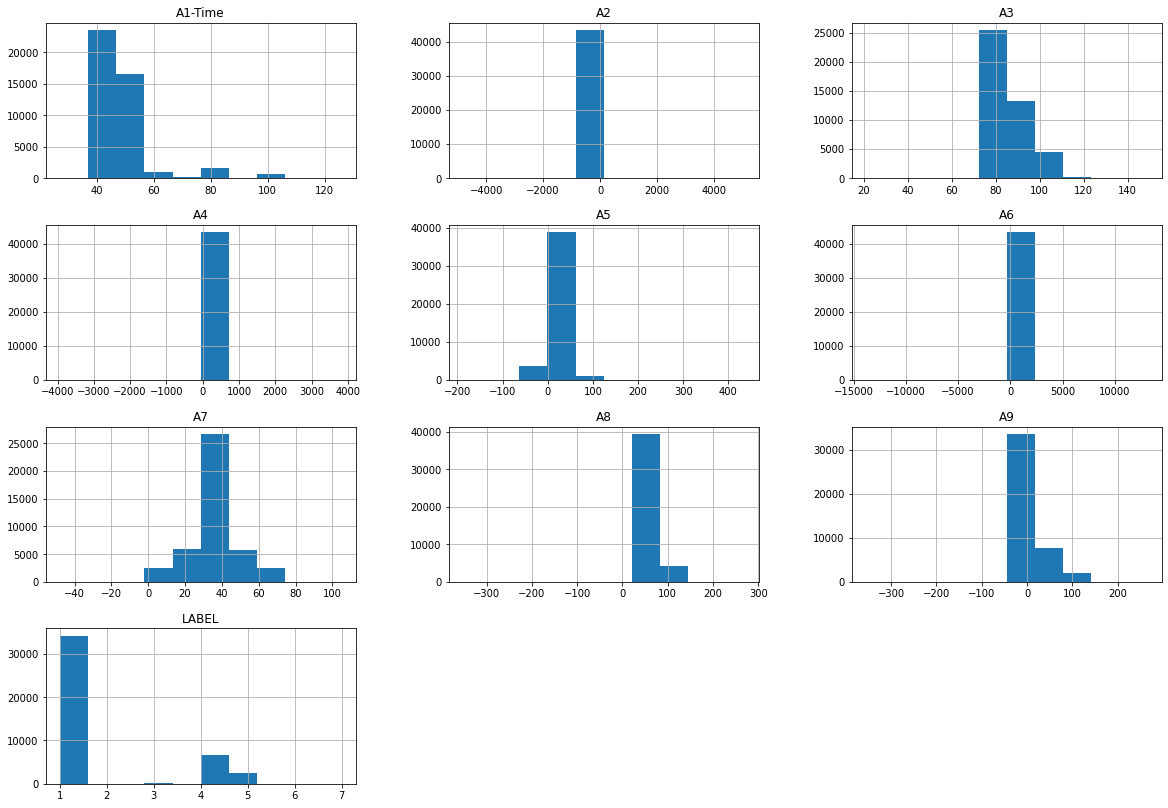

In [2]:
# Visualizing data to have a better idea of the data
# Plotting frequency of different attribute values since there are only 9 (+ 1 for assigned labels)
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy import stats
import numpy as np

# Visualize all numerical categories
dataset2_trn_full.hist(figsize=(20, 14))

'''
#removing outliers
subset=dataset2_trn.loc[:,'A2':'A9']
print(subset)
z_scores = stats.zscore(subset)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
print(filtered_entries)
dataset2_trn = dataset2_trn[filtered_entries]'''

print(dataset2_trn_full.describe())



            A1-Time            A2            A3            A4            A5  \
count  4.350000e+04  4.350000e+04  4.350000e+04  4.350000e+04  4.350000e+04   
mean   1.082965e-16  3.430206e-18  1.909482e-16  4.083579e-20 -1.454571e-16   
std    1.000011e+00  1.000011e+00  1.000011e+00  1.000011e+00  1.000011e+00   
min   -1.734323e+00 -6.169285e+01 -7.222492e+00 -9.607100e+01 -1.025329e+01   
25%   -8.365449e-01  2.625052e-03 -7.118554e-01 -6.407614e-03 -3.929742e-01   
50%   -2.652319e-01  2.625052e-03 -2.628460e-01 -6.407614e-03  3.442457e-01   
75%    5.509297e-01  2.625052e-03  4.106681e-01 -6.407614e-03  5.285506e-01   
max    6.345676e+00  6.494860e+01  7.145809e+00  9.339989e+01  1.849828e+01   

                 A6            A7            A8            A9  
count  4.350000e+04  4.350000e+04  4.350000e+04  4.350000e+04  
mean   8.167158e-20 -1.908665e-16 -5.014635e-17 -6.394885e-17  
std    1.000011e+00  1.000011e+00  1.000011e+00  1.000011e+00  
min   -7.711130e+01 -6.476736e+0

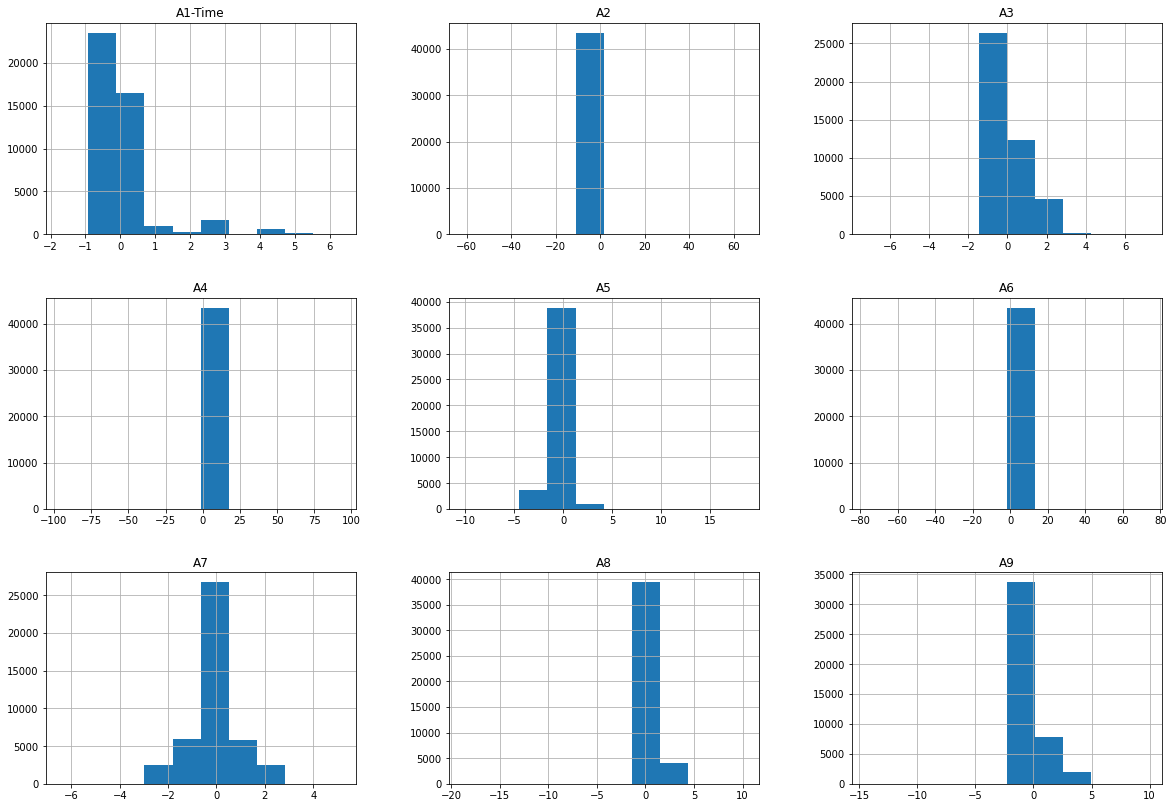

In [3]:
# Normalizing data since scales of some attributes are drastically different
from sklearn import preprocessing
names2_x=['A1-Time','A2','A3','A4','A5','A6','A7','A8','A9']
x_d2=dataset2_trn_full.loc[:,'A1-Time':'A9']
y_d2=dataset2_trn_full.loc[:,'LABEL']

'''min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x_train)
normalized_dataset_2 = pd.DataFrame(x_scaled, columns=names2)

normalized_dataset_2.hist(figsize=(20, 14))'''

scaler = preprocessing.StandardScaler()

# fit the scaler 
scaler.fit(x_d2)

# transform the data
x_train_normal = scaler.transform(x_d2)

normalized_xd2 = pd.DataFrame(x_train_normal, columns=names2_x)

normalized_xd2.hist(figsize=(20, 14))
#y_d2.hist(figsize=(20,14))
print(normalized_xd2.describe())




## One-hot coding
### No need for one-hot coding since all attributes and labels are numerical values

# Experiments Dataset #2

## Cross Validation

### Split training data into training and validation, start with 9:1 ratio (90% traning, 10% validation)

In [4]:

def splitTraining(p_val,num_instances):
    n_val=num_instances//p_val
    np.random.seed(5)
    inds = np.random.permutation(num_instances)
    x_val2,y_val2=normalized_xd2.loc[inds[:n_val],:],y_d2.loc[inds[:n_val]]
    x_train2,y_train2=normalized_xd2.loc[inds[n_val:],:],y_d2.loc[inds[n_val:]]
    
    return n_val, x_val2,y_val2, x_train2, y_train2

### Cross validation method

In [5]:
def cross_validate(total_nval, n_folds=5):
    #get the number of data samples in each split
    n_val = total_nval // n_folds
    np.random.seed(0)
    inds = np.random.permutation(total_nval)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexess
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, total_nval))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

### Setting up training/validation data sets and variables needed for hyperparameter analysis

In [6]:
(trn_instances, num_features) = dataset2_trn_full.shape
num_folds = 5

#split the data
(n_val, x_val2,y_val2, x_train2, y_train2)=splitTraining(10,trn_instances)
#converting training and validation dataframe sets to numpy arrays
x_val2=x_val2.to_numpy()
y_val2=y_val2.to_numpy()
x_train2=x_train2.to_numpy()
print(x_train2)
y_train2=y_train2.to_numpy()

#define a function for the MSE losss
loss = lambda y, yh: np.mean((y-yh)**2)

[[-0.91816106  0.00262505 -1.16086481 ...  0.07045449 -0.22829341
  -0.23255507]
 [-0.83654491  0.04101676 -0.59960304 ...  0.37497497 -0.46125242
  -0.5444689 ]
 [-0.346848    0.00262505 -1.16086481 ... -0.46245635 -0.78739504
  -0.46649044]
 ...
 [-0.59169645  0.00262505  1.86994874 ...  1.82144725  0.42399183
  -0.5444689 ]
 [-0.1836157   0.00262505  1.64544403 ...  1.28853641  0.09784921
  -0.5444689 ]
 [-0.42846415 -0.06136113 -0.48735069 ...  0.07045449 -0.64761963
  -0.5444689 ]]


# KNN

## Evaluating best number of K neighbors

In [72]:
'''from sklearn import neighbors

K_list=range(1,100)

err_train,err_valid = np.zeros(len(K_list)), np.zeros((len(K_list), num_folds))

#Evaluating best number of K neighbors
for i, K in enumerate(K_list):
    #Find the validation errors for num_folds splits for a given K
    model = neighbors.KNeighborsRegressor(n_neighbors=K)
    model = model.fit(x_train2, y_train2)
    err_train[i]= loss(y_train2, model.predict(x_train2))
    for f, (tr, val) in enumerate(cross_validate(n_val, num_folds)):
        model = neighbors.KNeighborsRegressor(n_neighbors=K)
        model = model.fit(x_val2[tr,:], y_val2[tr])
        err_valid[i, f] = loss(y_val2[val], model.predict(x_val2[val])) 
   
plt.plot(K_list, err_train,  label='train')
plt.errorbar(K_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('mean squared error')
plt.show()
'''

"from sklearn import neighbors\n\nK_list=range(1,100)\n\nerr_train,err_valid = np.zeros(len(K_list)), np.zeros((len(K_list), num_folds))\n\n#Evaluating best number of K neighbors\nfor i, K in enumerate(K_list):\n    #Find the validation errors for num_folds splits for a given K\n    model = neighbors.KNeighborsRegressor(n_neighbors=K)\n    model = model.fit(x_train2, y_train2)\n    err_train[i]= loss(y_train2, model.predict(x_train2))\n    for f, (tr, val) in enumerate(cross_validate(n_val, num_folds)):\n        model = neighbors.KNeighborsRegressor(n_neighbors=K)\n        model = model.fit(x_val2[tr,:], y_val2[tr])\n        err_valid[i, f] = loss(y_val2[val], model.predict(x_val2[val])) \n   \nplt.plot(K_list, err_train,  label='train')\nplt.errorbar(K_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')\nplt.legend()\nplt.xlabel('K (number of neighbours)')\nplt.ylabel('mean squared error')\nplt.show()\n"

## Evaluating neighbor weights

In [ ]:
'''from sklearn import neighbors

K_list=range(1,100)

err_train,err_valid = np.zeros(len(K_list)), np.zeros((len(K_list), num_folds))

#Evaluating best number of K neighbors
for i, K in enumerate(K_list):
    #Find the validation errors for num_folds splits for a given K
    model = neighbors.KNeighborsRegressor(n_neighbors=K, weights='distance')
    model = model.fit(x_train2, y_train2)
    err_train[i]= loss(y_train2, model.predict(x_train2))
    for f, (tr, val) in enumerate(cross_validate(n_val, num_folds)):
        model = neighbors.KNeighborsRegressor(n_neighbors=K)
        model = model.fit(x_val2[tr,:], y_val2[tr])
        err_valid[i, f] = loss(y_val2[val], model.predict(x_val2[val])) 
   
plt.plot(K_list, err_train,  label='train')
plt.errorbar(K_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('mean squared error')'''


## Evaluating best distance to use (Euclidean or Manhattan)

## Verifying custom cross-validation results against cross-validation package

In [73]:
from sklearn.model_selection import cross_val_score
#add sklearn cross val method for verification purposes


# Decision Tree

## Evaluating best split criterion without max depth limitation

[[0.         0.00114943 0.01609195 0.00114943 0.01954023]
 [0.         0.00114943 0.01609195 0.         0.01954023]]
[0. 0.]


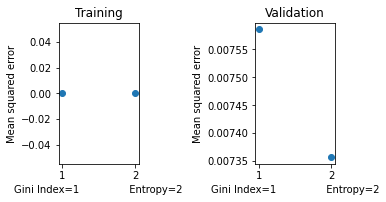

In [91]:
from sklearn import tree

criteria_list=["gini", "entropy"] 
err_train,err_valid = np.zeros(len(criteria_list)), np.zeros((len(criteria_list), num_folds))

model = tree.DecisionTreeClassifier()
model = model.fit(x_train2, y_train2)
err_train[0]= loss(y_train2, model.predict(x_train2))

for f, (tr, val) in enumerate(cross_validate(n_val, num_folds)):
        model = tree.DecisionTreeClassifier()
        model = model.fit(x_val2[tr,:], y_val2[tr])
        err_valid[0,f] = loss(y_val2[val], model.predict(x_val2[val])) 


model = tree.DecisionTreeClassifier(criterion="entropy")
model = model.fit(x_train2, y_train2)
err_train[1]= loss(y_train2, model.predict(x_train2))

for f, (tr, val) in enumerate(cross_validate(n_val, num_folds)):
        model = tree.DecisionTreeClassifier(criterion="entropy")
        model = model.fit(x_val2[tr,:], y_val2[tr])
        err_valid[1,f] = loss(y_val2[val], model.predict(x_val2[val])) 


print(err_valid)
print(err_train)
x=[1,2]

plt.subplot(1,2,1)
plt.scatter(x,err_train, label='training')
plt.xlabel('Gini Index=1                Entropy=2')
plt.ylabel('Mean squared error')
plt.title('Training')

plt.subplot(1,2,2)
plt.scatter(x,np.mean(err_valid, axis=1),label='validation')
#plt.errorbar(criteria_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='Validation')
plt.title('Validation')
plt.xlabel('Gini Index=1                Entropy=2')
plt.ylabel('Mean squared error')

plt.tight_layout(pad=5)
plt.show()

## Evaluating best max depth limitation with Gini index

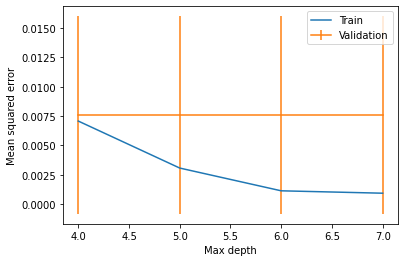

In [97]:
from sklearn import tree

max_depth=range(4,8)

err_train,err_valid = np.zeros(len(max_depth)), np.zeros((len(max_depth), num_folds))

#Evaluating value for max depth
for i, d in enumerate(max_depth):
    #Find the validation errors for num_folds splits for a given K
    model = tree.DecisionTreeClassifier(criterion='gini',max_depth=d)
    model = model.fit(x_train2, y_train2)
    err_train[i]= loss(y_train2, model.predict(x_train2))
    for f, (tr, val) in enumerate(cross_validate(n_val, num_folds)):
        model = tree.DecisionTreeClassifier(criterion='gini',max_depth=d)
        model = model.fit(x_val2[tr,:], y_val2[tr])
        err_valid[i, f] = loss(y_val2[val], model.predict(x_val2[val])) 
   
plt.plot(max_depth, err_train,  label='Train')
plt.errorbar(max_depth, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='Validation')
plt.legend()
plt.xlabel('Max depth')
plt.ylabel('Mean squared error')
plt.show()


## Evaluating best max depth limitation with Entropy 

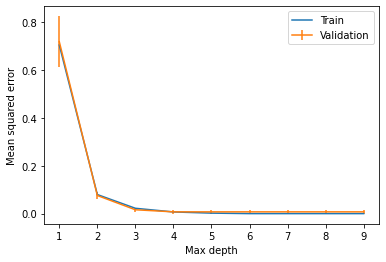

In [96]:
from sklearn import tree

max_depth=range(4,8)

err_train,err_valid = np.zeros(len(max_depth)), np.zeros((len(max_depth), num_folds))

#Evaluating value for max depth
for i, d in enumerate(max_depth):
    #Find the validation errors for num_folds splits for a given K
    model = tree.DecisionTreeClassifier(criterion='entropy',max_depth=d)
    model = model.fit(x_train2, y_train2)
    err_train[i]= loss(y_train2, model.predict(x_train2))
    for f, (tr, val) in enumerate(cross_validate(n_val, num_folds)):
        model = tree.DecisionTreeClassifier(criterion='entropy',max_depth=d)
        model = model.fit(x_val2[tr,:], y_val2[tr])
        err_valid[i, f] = loss(y_val2[val], model.predict(x_val2[val])) 
   
plt.plot(max_depth, err_train,  label='Train')
plt.errorbar(max_depth, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='Validation')
plt.legend()
plt.xlabel('Max depth')
plt.ylabel('Mean squared error')
plt.show()